# Positron Emission Tomography

## Introduction

In this notebook we will inspect a PET image. We will focus on the following activities:

* Inspecting DICOM metadata for PET/CT images
* Patient coordinates 
* Image co-registration
* PET Standardized Uptake Values (SUV)
* PET colormaps

## Image Formation

Positron Emission Tomography is the term used for tomographic images obtained by registering the counts of positrons that are emitted by a body after injection of a radiotracer. The image is formed by a weighted count of hits on the detector from X-rays that are generated by the annihilation of a positron when it encounters an electron. The resulting X-ray have a trajectory at 180-degrees that is detected by a scintillator allowing this to be converted into light. When X-rays strike two detectors at 180-degrees it is certain that the energy is from a positron and it is accounted for. The exact location of the emission can be obtained by the delay recorded by each detector.

The image pixels are formed by counts of postrons that are annihilated. The intensity will be higher from those pixels where move annihilation events occur which is where the radiotracer accumulates. Since the radiotracer is associated to a substance used by the body, the image directly reflects function. For instance, FDG is a radioactive glucose that will naturally accumulate where higher use of glucose is registered, such as malignant tumours.

Most of the time a PET scan is a full-body image since it is a very sensitive technique that can detect higher activity in tissues. It is then useful to locate possible metastases from a primary tumour.

In the files we will be using a series of PET images as well as it correspondent CT images from one participant are present. We will first open all the images independently and use an active visualization to observe the full body images.

**IMPORTANT NOTE: IF RUNNING THE NOTEBOOK IN AZURE NOTEBOOKS, MAKE SURE YOU ARE USING A PYTHON 3 KERNEL**

In [1]:
!pip install pydicom

    100% |████████████████████████████████| 7.0MB 153kB/s ta 0:00:011


## CT Images

These series of images, as it is the case for most PET scans, has a CT and a PET image to be overlaid. We will start opening the CT images and visualizing them.

In [2]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt

# As well as the DICOM package
import pydicom

InFile=0
FinalFile=89

fname='../library/./DICOMs/CT/{:06d}.dcm'.format(InFile+10)
print(fname)
RefDs = pydicom.read_file(fname)
DataType = RefDs.pixel_array.dtype
ArrayDicom3DCT = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=DataType)

imageindex=0
for ix in range(InFile,FinalFile+1):
    # Get file
    fname='../library/./DICOMs/CT/{:06d}.dcm'.format(ix)
    RefDs = pydicom.read_file(fname)
    # Finally we had already read the file and we have the image information in the pixel_array (final field)
    ArrayDicom3DCT[imageindex,:,:]=RefDs.pixel_array
    imageindex+=1

TotImagesCT=len(ArrayDicom3DCT[:,1,1])

../library/./DICOMs/CT/000010.dcm


In [3]:
from ipywidgets import interact, widgets

def show_imageCT(number_of_image):
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.axes().set_aspect('equal') #this makes the image square
    plt.set_cmap(plt.gray()) #grayscale    plt.imshow(ArrayDicom3D[ix,:,:])
    plt.imshow(ArrayDicom3DCT[number_of_image])
    plt.title(str(number_of_image))
    plt.show()
    
interact(show_imageCT,number_of_image= widgets.IntSlider(min=0,max=TotImagesCT-1,step=1,value=InFile));

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), Output()), _dom_classes=('wid…

We can see by browsing through the images that they are not in the order from head to feet as we would expect. We will then inspect the metadata and sort the images according to the slice in the patient's coordinates.

In [27]:
# And we will inspect the metadata here - Remember this is the metadata for the last file
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '18850827'
(0008, 0013) Instance Creation Time              TM: '111111'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.5168.2407.266566174900394277303263379210
(0008, 0020) Study Date                          DA: '18850827'
(0008, 0021) Series Date                         DA: '18850827'
(0008, 0022) Acquisition Date                    DA: '18850827'
(0008, 0023) Content Date                        DA: '18850827'
(0008, 0030) Study Time                          TM: '111111'
(0008, 0031) Series Time                         TM: '111111'
(0008, 0032) Acquisition Time                    TM: '154031'
(0008, 0033) Content Time                        TM: '154119'
(0008, 0060) Modality         

The **Image Position (Patient)** tag with the index 0x0020,0x0032 that has the information we require. We can access this using the return value from the dicom read at the index [0x0020, 0x0032] and it will be an array with three values that are the patient's coordinates. We will loop to see the position for each image and add this to the title of our image. 

There is other important information that we will need later in this metadata to convert to Hounsfield Units (see CT notebook for reference). We will collect that information now as well.

### Activity 1 - Comment on the code wherever you find #? what is the purpose of the line.

In [4]:
ImagePositionCT=np.zeros((TotImagesCT,3))     #Creating an array of zeros with the length of TotImagesCT rows x 3 columns
RescaleSlopeCT=np.zeros(TotImagesCT)     #Creating a 1D array of zeros the length of TotImagesCT (the number of CT images we have in total)
RescaleInterceptCT=np.zeros(TotImagesCT)     #Same as above  

indeximage=0
for ix in range(InFile,FinalFile+1):   #A loop that will repeat as ix increments by 1 from 0 to 89+1 (these values were assigned to these variables at the start)  
    fname='../library/./DICOMs/CT/{:06d}.dcm'.format(ix)
    RefDs = pydicom.read_file(fname)      #Opens the file fname for reading and sets the variable RefDs 
    ImagePositionCT[indeximage,:]=RefDs[0x0020, 0x0032][:]   #Puts image position tag index into thr ImagePositionCT array at the current index position 
    RescaleSlopeCT[indeximage]=RefDs.RescaleSlope  #Sets RescaleSlopeCT at the current index to the Rescale Slope of the current image (metadata) 
    RescaleInterceptCT[indeximage]=RefDs.RescaleIntercept #Sets RescaleInterceptCT at the current index to the Rescale Intercept of the current image (metadata)  
    indeximage+=1    #Incrementing by 1 the array index

### Activity 2 - Add a code cell below using the code with the widget from above modified to have on the title the information in Image Position for the patient. 

We can now see that it is the third coordinate the one that corresponds to the SI (superior-inferior) coordinates and that it has a higher value where the head than for the body. This is the usual convention for head (+) and feet (-) in the RAS reference. We will sort the images depending on the coordinates and we should now have images from the shoulders to the top of the head.

In [5]:
HeadCoordinates=ImagePositionCT[:,2]   #We keep in this array all the Head/Feet coordinates for the mages [2]
IndexesSorted=np.argsort(HeadCoordinates)  #And sort them

ArrayDicom3DCT_Sorted = np.zeros(np.shape(ArrayDicom3DCT),dtype=DataType)
ArrayDicom3DCT_Sorted = ArrayDicom3DCT[IndexesSorted]             #This array has now all the images sorted 
ImagePositionCT_Sorted = np.zeros(np.shape(ImagePositionCT))      
ImagePositionCT_Sorted = ImagePositionCT[IndexesSorted]           #This array has now all the image position coordinates sorted 

RescaleSlopeCT_Sorted = np.zeros(np.shape(RescaleSlopeCT))            
RescaleSlopeCT_Sorted = RescaleSlopeCT[IndexesSorted]                 #This array has now all the Rescale Slope sorted 
RescaleInterceptCT_Sorted = np.zeros(np.shape(RescaleInterceptCT))  
RescaleInterceptCT_Sorted = RescaleInterceptCT[IndexesSorted]         #This array has now all the Rescale Intercept sorted

def show_imageCT_sorted(number_of_image):
    
    global ImagePositionCT_Sorted
    
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.axes().set_aspect('equal') #this makes the image square
    plt.set_cmap(plt.gray()) #grayscale    plt.imshow(ArrayDicom3D[ix,:,:])
    plt.imshow(ArrayDicom3DCT_Sorted[number_of_image])
    plt.title('Image='+str(number_of_image)+' Position='+str(ImagePositionCT_Sorted[number_of_image]))
    plt.show()
    
interact(show_imageCT_sorted,number_of_image= widgets.IntSlider(min=0,max=TotImagesCT-1,step=1,value=InFile));  

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), Output()), _dom_classes=('wid…

# Challenge \#12
It is possible to create an animation using *matplotlib* to generate a video file. Create a video of the images above and show it in a code cell below.

Note: you can check the documentation for **matplotlib.animation.Animation** and you would need to run this in a local environment (not Azure) since it requires some local installs for ffmpeg libraries and programs for video production.

In [6]:
import io
import base64
from IPython.display import HTML

video = io.open('../library/FullBodyCT.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## PET Image

We will now repeat a similar process for the PET images.

We will first open all the images.

In [7]:
InFile=0
FinalFile=89

# Read all PET files
fname='../library/./DICOMs/PET/{:06d}.dcm'.format(InFile+10)
print(fname)
RefDs = pydicom.read_file(fname)
DataType = RefDs.pixel_array.dtype
ArrayDicom3DPET = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=DataType)
ImagePositionPET=np.zeros((FinalFile-InFile+1,3))   
TotImagesPET=FinalFile-InFile+1

imageindex=0
for ix in range(InFile,FinalFile+1):
    # Get file
    fname='../library/./DICOMs/PET/{:06d}.dcm'.format(ix)
    RefDs = pydicom.read_file(fname)
    ArrayDicom3DPET[imageindex,:,:]=RefDs.pixel_array
    ImagePositionPET[imageindex,:]=RefDs[0x0020, 0x0032][:]   
    imageindex+=1  

../library/./DICOMs/PET/000010.dcm


### Activity 3 - Copy and paste cells from the CT code above to inspect all the PET images that were opened using widgets. Preferably show the position in the title already.

In [9]:
##Activity 3 ##
HeadCoordinates=ImagePositionPET[:,2]
IndexesSorted=np.argsort(HeadCoordinates)

ArrayDicom3DPET_Sorted = np.zeros(np.shape(ArrayDicom3DPET), dtype=DataType)  
ArrayDicom3DPET_Sorted = ArrayDicom3DPET[IndexesSorted]
ImagePositionPET_Sorted = np.zeros(np.shape(ImagePositionPET))
ImagePositionPET_Sorted = ImagePositionPET[IndexesSorted]

def show_imagePET_sorted(number_of_image):
    
    global ImagePositionPET_Sorted
    
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.axes().set_aspect('equal') #this makes the image square
    plt.set_cmap(plt.gray()) #grayscale    plt.imshow(ArrayDicom3D[ix,:,:])
    plt.imshow(ArrayDicom3DPET_Sorted[number_of_image])
    plt.title('Image='+str(number_of_image)+' Position='+str(ImagePositionPET_Sorted[number_of_image]))
    plt.show()
    
interact(show_imagePET_sorted,number_of_image= widgets.IntSlider(min=0,max=TotImagesPET-1,step=1,value=InFile));  

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), Output()), _dom_classes=('wid…

# Challenge \# 13

Re-code the functions for opening CT and PET images defining functions for most of the common code and calling those functions instead of repeating code. One of the functions should return a 3D array with all the images already sorted.

## PET Images Scale

We will inspect the metadata of a PET image to explain some concepts about dose and the scale for the images in PET.

In [10]:
print(RefDs)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '18850827'
(0008, 0013) Instance Creation Time              TM: '111111'
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.14519.5.2.1.5168.2407.335605164322770524664245774978
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.5168.2407.226076618102691603310797296793
(0008, 0020) Study Date                          DA: '18850827'
(0008, 0021) Series Date                         DA: '18850827'
(0008, 0022) Acquisition Date                    DA: '18850827'
(0008, 0023) Content Date                        DA: '18850827'
(0008, 0030) Study Time                          TM: '111111'
(0008, 0031) Series Time                         TM: '111111'
(0008, 0032) Acquis

In PET the image information is given in Standardized Uptake Values (SUV) which is a unitless value that quantifies the activity  in a target region of the body per injected activity into the subject. 

$$ SUV=\frac{c_{ROI}}{c_{inj}}$$

We usually have information about the injected dose in $Ci/mL$ (dose) so we need to account for the *density* of the subject (from the weight) to calculate the activity injected.

$$ c_{inj}=\frac{dose}{weight}$$

Since we usually assume the density is that of water.

Typical values for SUV are around 0.5 for breast, 0.7 for lung, 1.0 for bone marrow, 2.5 for liver and above 2.0 for tumours.

The pixel values in a DICOM are intensities that have been again scaled to use the whole dynamic of the image. So we will need to adjust to obtain the *real* value given in activity using the **Rescale Slope** and **Rescale Intercept** from the metadata.

$$Rescaled\_Intensity_{ROI}=Rescale\_Slope \times intensity + Rescale\_Intercept$$

And the information for the injected dose is given as a **Dose Calibration Factor** in the metadata gives the pixel intensity that accounts for $1 Bq/mL$ so that the intensity is then given in $Bq/mL$.

$$c_{ROI}=Rescaled\_Intensity_{ROI} / Dose\_Calibration\_Factor$$

The units are also in the metadata as **Units** and they can be in $Ci/mL$ but often they are $Bq/mL$. The Becquerel is preferred since it is based on the decay of a nucleus per second whereas the Curie is based on the activity of 1 gram of Ra-226. We can convert $1 Ci=3.7\times10^{10} Bq=37 GBq$.

We will extract that information from the metadata in the following cell code. The dose calibration is the same for all the images since the same PET scanner was used but the slope and intercept may change per image to accommodate for the use of all the dynamic on the encoding. We will then verify if the values are or not unique for this patient.

In [11]:
# We will obtain all the values for the group of images
indeximage=0
Rescale_SlopePET=np.zeros(TotImagesPET)
Rescale_InterceptPET=np.zeros(TotImagesPET)
DoseCalibration=np.zeros(TotImagesPET)
Units=[]
for ix in range(InFile,FinalFile+1):   #? Loop to go through all the files
    fname='../library/./DICOMs/PET/{:06d}.dcm'.format(ix)
    RefDs=pydicom.read_file(fname)      #? Reads the DICOM 
    Rescale_SlopePET[indeximage] = RefDs.RescaleSlope
    Rescale_InterceptPET[indeximage] = RefDs.RescaleIntercept
    Units.append(RefDs.Units)
    DoseCalibration[indeximage] = RefDs.DoseCalibrationFactor
    indeximage+=1    #? increases the index for the image in the array
    
# And we print the unique values for each parameter
print('The Rescale Slope values are '+str(np.unique(Rescale_SlopePET)))
print('The Rescale Intercept values are '+str(np.unique(Rescale_InterceptPET)))
print('The Units values are '+ str(np.unique(Units)))
print('The Dose Calibration Factor value '+str(np.unique(DoseCalibration))+' intensity is 1 '+str(np.unique(Units)))

The Rescale Slope values are [0.206447 0.237032 0.25593  0.348698 0.373596 0.374572 0.376279 0.379915
 0.382574 0.398615 0.400053 0.402078 0.403426 0.416387 0.426769 0.427103
 0.432426 0.438185 0.439943 0.445382 0.451772 0.458349 0.472107 0.473474
 0.474143 0.47535  0.475818 0.479293 0.487741 0.490103 0.542514 0.551786
 0.556774 0.560643 0.58374  0.585006 0.664707 0.814305 0.839418 0.90916
 1.00548  1.07632  1.16478  1.20344  1.2203   1.23254  1.24117  1.24313
 1.27615  1.29348  1.30034  1.34059  1.34612  1.348    1.35181  1.3867
 1.38956  1.40496  1.40683  1.40835  1.43686  1.4673   1.46998  1.47011
 1.48623  1.48708  1.49014  1.50187  1.52384  1.55437  1.56505  1.56707
 1.57109  1.6075   1.63325  1.64051  1.6439   1.64999  1.65173  1.65437
 1.66182  1.69047  1.70276  1.71586  1.80039  1.97429  2.17868  2.19889
 2.25454  2.30053 ]
The Rescale Intercept values are [0.]
The Units values are ['BQML']
The Dose Calibration Factor value [36972.] intensity is 1 ['BQML']


It can be observed that the Slope is different for each image, the Intercept is the same for all and as expected the calibration and the units are identical for all images.

We will now obtain the SUV for the PET images.

In [12]:
DoseCalibrationValue=np.unique(DoseCalibration)
Rescale_SlopePET_Sorted=Rescale_SlopePET[IndexesSorted]
Rescale_InterceptPET_Sorted=Rescale_InterceptPET[IndexesSorted]

#ATTENTION: we have an array that is limited to 16 bits and multiplying by anything above 1 may overflow so we will move
#everything into a float array
ArrayDicom3DPET_Converted=np.zeros(np.shape(ArrayDicom3DPET_Sorted))   #by default it will be a float 

for ix in range(TotImagesPET):
    ArrayDicom3DPET_Converted[ix,:,:]=ArrayDicom3DPET_Sorted[ix,:,:]*Rescale_SlopePET_Sorted[ix]+Rescale_InterceptPET_Sorted[ix]

ArrayDicom3DPET_Converted=ArrayDicom3DPET_Converted/DoseCalibrationValue

def show_imagePET_converted(number_of_image):
    
    global ImagePositionPET_Sorted
    
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.axes().set_aspect('equal') #this makes the image square
    plt.set_cmap(plt.gray()) #grayscale    plt.imshow(ArrayDicom3D[ix,:,:])
    plt.imshow(ArrayDicom3DPET_Converted[number_of_image])
    plt.title('Image='+str(number_of_image)+' Position='+str(ImagePositionPET_Sorted[number_of_image]))
    plt.show()
    
# And we can all again the interactive image for the now converted array    
interact(show_imagePET_converted,number_of_image= widgets.IntSlider(min=0,max=TotImagesPET-1,step=1,value=InFile));

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), Output()), _dom_classes=('wid…

We will now show the scale in the usual *plasma* colormap that isused in PET. We will also observe the effect of masking low SUV values which is often done to eliminate background activity. 

In [13]:
from ipywidgets import fixed

def show_imagePET_final(number_of_image,map_low_threshold,map_high_threshold):
    
    global ImagePositionPET_Sorted
    
    fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
    plt.axes().set_aspect('equal') #this makes the image square
    plt.set_cmap(plt.gray()) #grayscale    plt.imshow(ArrayDicom3D[ix,:,:])
    vminV=min(map_low_threshold,np.max(ArrayDicom3DPET_Converted[number_of_image]))
    plt.imshow(ArrayDicom3DPET_Converted[number_of_image], cmap='plasma', vmin=vminV, vmax=map_high_threshold)
    plt.title('Image='+str(number_of_image)+' Position='+str(ImagePositionPET_Sorted[number_of_image]))
    plt.show()
    
MAXSUV=np.max(ArrayDicom3DPET_Converted)
# And we can all again the interactive image for the now converted array    
interact(show_imagePET_final,number_of_image= widgets.IntSlider(min=0,max=TotImagesPET-1,step=1,value=InFile),
         map_low_threshold = widgets.FloatSlider(min=0.,max=np.max(ArrayDicom3DPET_Converted),step=0.01,value=0.2),
         map_high_threshold=fixed(MAXSUV));

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), FloatSlider(value=0.2, descri…

An SUV of 0.14 seems an adequate value to threshold the image and eliminate values that are in the bone for instance. We will finally overlay the PET image on the CTs and use some segmentation so we only have the SUV overlay within the tissues.

## Image overlay

In order to do an appropriate overlay, we should do a series of activities:

- Convert the CT image into density information using the method discussed in the CT Notebook
- Reduce the size of this image since this CT is larger than the PET area
- Use a segmentation mask from the CT to only display SUV data inside the body
- Define appropriate transparencies to allow for simultaneous visualization of CT and PET information

### Activity 4 - Using code from your other notebooks, prepare the histogram for the first image in the CT series and determine a threshold for segmentation based on that information.
<br><font color=red>The original threshold of 800 was very effective. As we can see in the histogram below, a threshold of 800 would eliminate many darker intensities, leaving the bulk of the intensities in the body. I actually lowered the threshold to 700 as it fills in some small gaps in the body. </font>

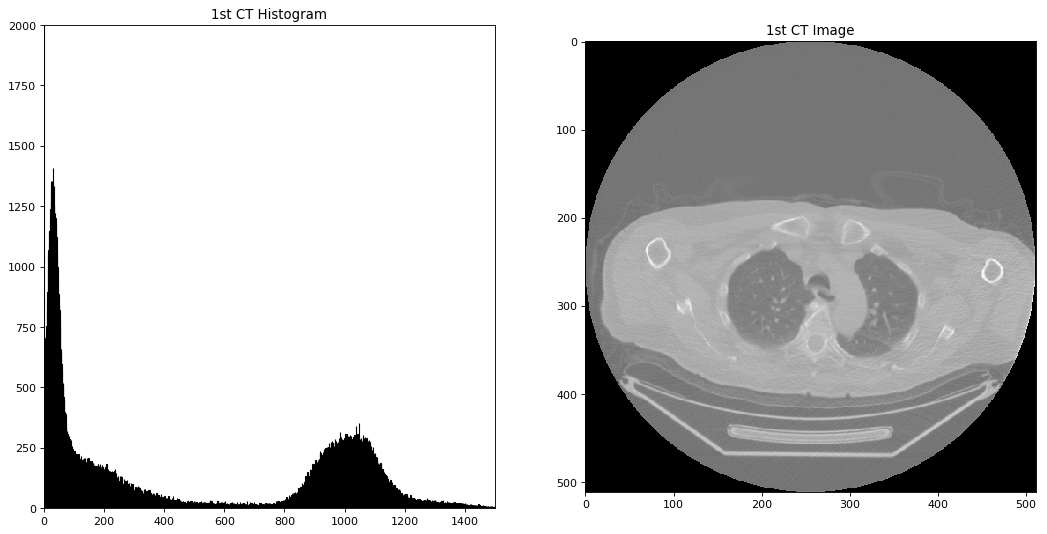

In [32]:
### Activity 4 ###
#First image
hist,bins = np.histogram(ArrayDicom3DCT_Sorted[0].flatten(),1500,[0,1500])
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.subplot(121)
plt.hist(ArrayDicom3DCT_Sorted[0].flatten(), 1500, [0,1500], fc='k', ec='k')
plt.title('1st CT Histogram')
plt.ylim([0,2000])
plt.xlim([0,1500])

plt.subplot(122)
plt.title('1st CT Image')
plt.imshow(ArrayDicom3DCT_Sorted[0])


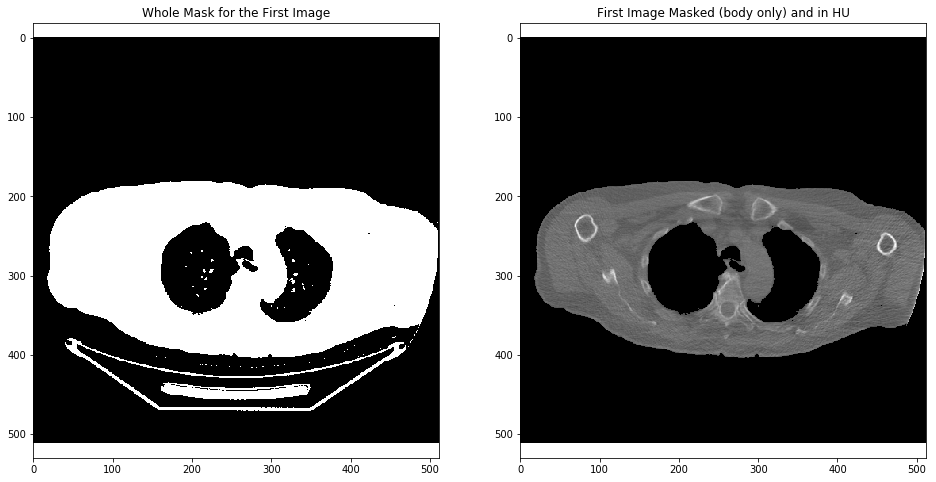

In [36]:
import cv2
###### SEGMENTATION

SegmentedArrayDicom3DCT = np.zeros(np.shape(ArrayDicom3DCT_Sorted), dtype=RefDs.pixel_array.dtype)

Threshold = 700

mask3D = np.zeros_like(ArrayDicom3DCT_Sorted,'uint8')
mask3D[ArrayDicom3DCT_Sorted <= Threshold] = 0          
mask3D[ArrayDicom3DCT_Sorted > Threshold] = 1

TotImagesCT=len(ArrayDicom3DCT_Sorted[:,1,1])

for ix in range(0,TotImagesCT):
    ret, markers = cv2.connectedComponents(mask3D[ix])  #this will detect all the regions within the mask
    # to determine which of the regions has the highest number of pixels we can use a histogram
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    # the highest number of pixels are evidently on the black, so we look for the second highest
    inxhist=np.argsort(hist)  #indexes of the sorted histogram
    inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent = zeros)
    ROI=np.zeros_like(ArrayDicom3DCT_Sorted[ix],'uint8')
    ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
    SegmentedArrayDicom3DCT[ix,:,:]=ROI*ArrayDicom3DCT_Sorted[ix,:,:]   #segmenting the image only to bone
    
###### CONVERTING CT INTO HU
# We had collected and sorted Rescale Slope and Rescale Intercept when reading and sorting the CT images.
# We will use that information here to convert to HU

for ix in range(TotImagesCT):
    SegmentedArrayDicom3DCT[ix,:,:]=RescaleSlopeCT_Sorted[ix]*SegmentedArrayDicom3DCT[ix]+RescaleInterceptCT_Sorted[ix]

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(mask3D[0])
plt.title('Whole Mask for the First Image')
plt.axis('equal') #this makes the image square
plt.subplot(122)
plt.imshow(SegmentedArrayDicom3DCT[0])
plt.axis('equal') #this makes the image square
plt.title('First Image Masked (body only) and in HU')
plt.show()



We will now use the metadata information in **Pixel Spacing** to obtain the size of the PET and CT images. This will be used to rescale and overlay the images (they have different sizes).

In [15]:
# We read one PET and one CT image

# Get first CT file - we will use the fact that all images in the series have the same initial pixel, pixel spacing
# number of columns and rows. This may be unique to our dataset !
fname='../library/./DICOMs/CT/{:06d}.dcm'.format(0)
RefDs = pydicom.read_file(fname)
CTPixelSpacing=RefDs.PixelSpacing
CTColumns=RefDs.Columns
CTInitialPixel=ImagePositionCT[0,0:2]  

# Get first PET file - we will use the fact that all images in the series have the same initial pixel, pixel spacing
# number of columns and rows. This may be unique to our dataset !
fname='./DICOMs/PET/{:06d}.dcm'.format(0)
RefDs = pydicom.read_file(fname)
PETPixelSpacing=RefDs.PixelSpacing
PETColumns=RefDs.Columns
PETInitialPixel=ImagePositionPET[0,0:2]

print('CTs are '+str(CTColumns)+' wide with Pixel Spacing of '+
      str(CTPixelSpacing)+'='+str(CTColumns*CTPixelSpacing[0])+' mm'+
      '. The first pixel is '+ str(CTInitialPixel))
print('PETs are '+str(PETColumns)+' wide with Pixel Spacing of '+
      str(PETPixelSpacing)+'='+str(PETColumns*PETPixelSpacing[0])+' mm'+
     '. The first pixel is '+str(PETInitialPixel))

CTs are 512 wide with Pixel Spacing of ['0.976562', '0.976562']=499.999744 mm. The first pixel is [-250. -250.]
PETs are 128 wide with Pixel Spacing of ['3.515625', '3.515625']=450.0 mm. The first pixel is [-223.2421875 -223.2421875]


We will now cut the CT image to the same size and starting at the same coordinate as the PET by cutting $[CT_{first\ pixel}-PET_{first\ pixel}]/PixelSpacing_{CT}$ pixels on the left, the rest to reach the same size as the PET on the right.

And then we calculate the subsampling on CTs so we can generate and shrink a mask to overlay the segmented CT.

We will cut 27 on the left and 24 on the right


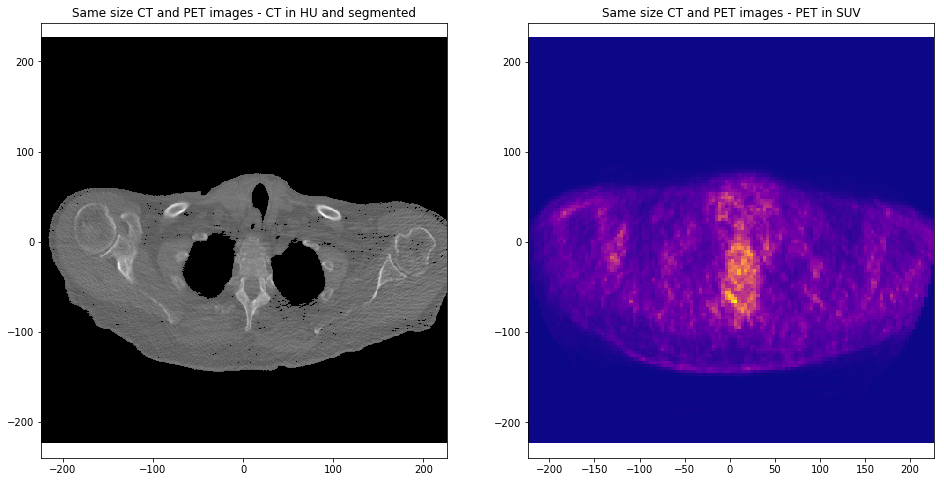

In [16]:
# We will cut a total of pixels to make both images the same size
PixelsToCut=int(round(int(round(CTColumns*CTPixelSpacing[0])-round(PETColumns*PETPixelSpacing[0]))/CTPixelSpacing[0]))

# First Pixel taken from information on the first image (I am using the fact that X and Y are equal, this may be unique to this)
# dataset!
FirstPixelCT=ImagePositionCT[0,0:1]    
FirstPixelPET=ImagePositionPET[0,0:1]

# We need to cut a certain number of pixels so both images start at the same coordinate
PixelsToCutL=int(round(abs(FirstPixelCT[0]-FirstPixelPET[0])/CTPixelSpacing[0]))

# The number of pixels to cut in the right is given by the difference between the total pixels to cut and what
# we cut to make the first coordinate the same
PixelsToCutR=PixelsToCut-PixelsToCutL

print('We will cut '+str(PixelsToCutL)+' on the left and '+str(PixelsToCutR)+' on the right')

# The new size of the CT is then
CTColumnsResized=CTColumns-PixelsToCutL-PixelsToCutR

# And we eliminate that part of the array in the CT
SegmentedArrayDicom3DCT_Resized=np.zeros((TotImagesCT,CTColumnsResized,CTColumnsResized))
SegmentedArrayDicom3DCT_Resized[:,:,:]=SegmentedArrayDicom3DCT[:,PixelsToCutL:-PixelsToCutR,PixelsToCutL:-PixelsToCutR]

# The new first pixel in the CT is
FirstPixelCT=FirstPixelCT+PixelsToCutL*CTPixelSpacing[0]

# We show the images with their correct axes
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(SegmentedArrayDicom3DCT_Resized[InFile+10], extent=[FirstPixelCT[0],
                                                               FirstPixelCT[0]+CTColumnsResized*CTPixelSpacing[0],
                                                               FirstPixelCT[0],
                                                               FirstPixelCT[0]+CTColumnsResized*CTPixelSpacing[0]])
ax = plt.gca()
plt.axis('equal') #this makes the image square
plt.title('Same size CT and PET images - CT in HU and segmented')
plt.subplot(122)
plt.imshow(ArrayDicom3DPET_Converted[InFile+10], cmap='plasma', extent=[FirstPixelPET[0],
                                               FirstPixelPET[0]+PETColumns*PETPixelSpacing[0],
                                               FirstPixelPET[0],
                                               FirstPixelPET[0]+PETColumns*PETPixelSpacing[0]])
ax = plt.gca()
plt.axis('equal') #this makes the image square
plt.title('Same size CT and PET images - PET in SUV')

plt.show()

## Overlay and transparency

One of the most used methods to overlay two kinds of medical images is to define one of the images as a transparent one and overlay this on the other modality. This is what we will do to overlay the images above. Because we have zeros outside of the body this will *erase* information outside of the body and the structures in the CT will be visible underneath the PET image.

In transparency what we do is to define an additional channel to the image called the *alpha* channel. This allows the rendering to now they have to apply transparency defined by this channel to the image. This is done to combine an image with a background to create the appearance of partial or full transparency. In our case, we will define an alpha channel defined by the CT image - the image will be more or less transparent depending on the values in the CT - and apply this to the PET image. We will then need both images to be the same size and we will first subsample the CT for this purpose. We will also need to normalize the colours in the PET, since otherwise the scales may be very different. 

Finally, we will render both images on the same figure, but since the PET image will have a transparency defined by the underlying CT, it will not cover the CT and they will both be visible.

In [37]:
from matplotlib.colors import Normalize    #required to normalize colors

# Here we subsample the CT - note that the coordinates of the pixels may be very different because of pixel spacing
# so we have this code to find the closest coordinate for the subsampling instead of simply go for straight subsampling
# by taking every X index 

CTcoordinatesX=np.linspace(FirstPixelCT,FirstPixelCT+CTPixelSpacing[0]*CTColumnsResized,CTColumnsResized)
CTcoordinatesY=np.linspace(FirstPixelCT,FirstPixelCT+CTPixelSpacing[0]*CTColumnsResized,CTColumnsResized)

PETcoordinatesX=np.linspace(FirstPixelPET,FirstPixelPET+PETPixelSpacing[0]*PETColumns,PETColumns)
PETcoordinatesY=np.linspace(FirstPixelPET,FirstPixelPET+PETPixelSpacing[0]*PETColumns,PETColumns)

SubSampledCT=np.zeros((TotImagesCT,PETColumns,PETColumns))

for ixx in range(PETColumns):
    nearestX=np.where(CTcoordinatesX>=PETcoordinatesX[ixx])
    for ixy in range(PETColumns):
        nearestY=np.where(CTcoordinatesY>=PETcoordinatesY[ixy])
        if ((nearestY[0].size>0) & (nearestX[0].size>0)):
            SubSampledCT[:,ixx,ixy]=SegmentedArrayDicom3DCT_Resized[:,nearestX[0][0],nearestY[0][0]]

# We will loop the overlay for all images
PEToverlays=np.zeros((TotImagesCT,PETColumns,PETColumns,4))  #this array will keep the PET image, since it is coloured
                                                             #it needs 4 coordinates (R,G,B,alpha)

for ix in range(TotImagesCT):
    
    # Create an alpha channel with the CT image
    alphas = SubSampledCT[ix]

    # Normalize the PET colours between 0 and 1 
    vmax=np.max(ArrayDicom3DPET_Converted[ix])
    vmin=np.min(ArrayDicom3DPET_Converted[ix])
    PETcolours = Normalize(vmin, vmax, clip=True)(ArrayDicom3DPET_Converted[ix])
    cmap=plt.cm.viridis#plasma   #we first define a coloup map object based on plasma (which is the preferred map for PET)

    PETcolours = cmap(PETcolours)   #we define here the PETcolours mapped according to the cmap that has the plasma scale

    # Now add to those PETcoulours the alpha channel we created above
    PETcolours[..., -1] = alphas
    PEToverlays[ix]=PETcolours

from ipywidgets import interact, widgets

def overlay_PET_CT(number_of_image):
    
    global FirstPixelCT, CTColumnsResized, CTPixelSpacing
    global FirstPixelPET, PETColumns, PETPixelSpacing
        
    # We create the figure and display the images
    fig, ax = plt.subplots(figsize=(10, 10))
    # We display here the CT
    ax.imshow(SegmentedArrayDicom3DCT_Resized[number_of_image],extent=[FirstPixelCT[0],
                                                                       FirstPixelCT[0]+CTColumnsResized*CTPixelSpacing[0],
                                                                       FirstPixelCT[0],
                                                                       FirstPixelCT[0]+CTColumnsResized*CTPixelSpacing[0]])
    # We display here the PET colours
    ax.imshow(PEToverlays[number_of_image],interpolation='nearest', extent=[FirstPixelPET[0],
                                                                            FirstPixelPET[0]+PETColumns*PETPixelSpacing[0],
                                                                            FirstPixelPET[0],
                                                                            FirstPixelPET[0]+PETColumns*PETPixelSpacing[0]])
    plt.show()
    
interact(overlay_PET_CT,number_of_image= widgets.IntSlider(min=0,max=TotImagesCT-1,step=1,value=0));    

interactive(children=(IntSlider(value=0, description='number_of_image', max=89), Output()), _dom_classes=('wid…

### Activity 5 - Inspecting the overlaid images above answer the following questions: 1) what part of the body is included in these images?; 2) what is the organ with the highest radiation activity and why?; 3) can you have an educated guess on where the tumour is located (image number) and explain why you made that choice; 4) modify the code above to use different colormaps, is there a map that you prefer to visualize activity? Explain.
<br><font color=red>
1) These images are of the head and neck, down to the shoulders. <br>
2) The organ with the highest radiation activity is the brain because it is extremely active and metabolizes a lot of glucose<br>
3) Around image 30 is where I suspect the tumor is (throat area/ lymph node?). Between images 25 and 35 there is a small area that has much higher activity than the surrounding area. It is very clear in image 30. As this is no longer the brain activity, I would suspect that this is the tumor.<br>
4) I liked the viridis colormap because it provided really clear contrast between active/non active areas. I found inferno to be harder to read due to similar colours. <br></font>

In [18]:
import io
import base64
from IPython.display import HTML

video = io.open('../library/FullBodyPET.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## Summary

In this example we:

* Showed how to open and inspect a DICOM image from a CT and a PET scan
* Visualized a video where slices of multiple CTs are shown
* Calculated the SUV based on the pixel information from a PET image
* Segmented the bone from a CT image 
* Made an overlay of two medical images that were co-registered using transparency and color scales

Comments and corrections welcome!

References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.
* https://docs.scipy.org
* Kinehan, P. E., and J. W. Fletcher. "PET/CT standardized uptake values (SUVs) in clinical practice and assessing response to therapy." Semin Ultrasound CT MR 31.6 (2010): 496-505.